# Challenge

## Assignment
Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

## Import the Data
The data is over 20k recipes from epicurious.com. It consists of the title of each recipe, the rating, calories, nutritional values, and ingredients for each of the recipes. This data will be imported and explored below:

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Import the data and print the first 5 rows
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')
df.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


## Removing NaN Values
4000 values are missing in each of the nutritional values. These values will be interpolated based on the values in the row. 

In [4]:
# Count of missing values
df.isna().sum().nlargest()

fat         4183
protein     4162
sodium      4119
calories    4117
title          0
dtype: int64

In [5]:
# Fill missing values based on row values
df = df.interpolate(axis=0)

## Data Exploration
The main question in mind when looking at this data set is, how does one predict the rating of a recipe? The names of all the columns are printed below to explore all the different variables with that question in mind. Looking at the list below, it looks like there are several categories in the data:
    1. Nutritional Values
    2. Type of receipe
    3. Event
    4. Location
    5. Ingredients

### Rating Exploration
The distribution plot below identified several key problems. First, there are a lot of receipes with a rating score of zero, which indicates there is no reviews for 1800 receipes. The mean of the data is skewed because of this. The mean of the data is 3.71, while the 25% quartile is 3.75. Second, this distribution shows that there is a clear bias in the reviewers to give higher reviews.

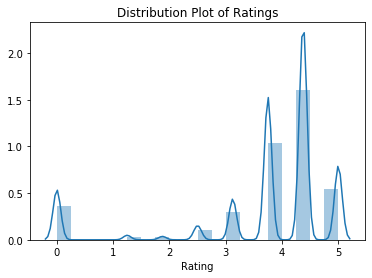

In [6]:
# Plot a violinplot of the ratings
sns.distplot(df['rating'], bins=20)
plt.xlabel('Rating')
plt.title('Distribution Plot of Ratings')
plt.show()

In [7]:
# Statistics of the ratings
df['rating'].describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

#### Zero Rated Receipes
Roughly 10% of the data has no rating. Furthermore, the target variable needs to be converted to a integer to be fitted to the SVC model. 

In [8]:
# Print list of the counts per review
df['rating'].value_counts().sort_index()

0.000    1836
1.250     164
1.875     124
2.500     532
3.125    1489
3.750    5169
4.375    8019
5.000    2719
Name: rating, dtype: int64

In [9]:
# round the ratings and convert to integer
df['rating'] = round(df['rating']).astype('int')
df['rating'].value_counts().sort_index()

0     1836
1      164
2      656
3     1489
4    13188
5     2719
Name: rating, dtype: int64

## SVM Classifer Model 1
Model 1 performed horribly with only a cross validation score of .65. Additionally, the model was had a large number of false positives in relation to review 4. 

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

svc = SVC()
# X is the features
X = df.drop(['title', 'rating'], axis=1)

# Y is the target variable
Y = df['rating']

# Split the data between test and train sets
x_train, x_test, y_train, y_test = train_test_split(X, Y,
        test_size=.2, random_state=1)

# Fit the training data to the model
svc.fit(x_train, y_train)

# Cross validation with 5 folds
from sklearn.model_selection import cross_val_score
cross_val_score(svc, x_train, y_train, cv=5)

array([0.65981308, 0.66074766, 0.65887122, 0.66011849, 0.6619894 ])

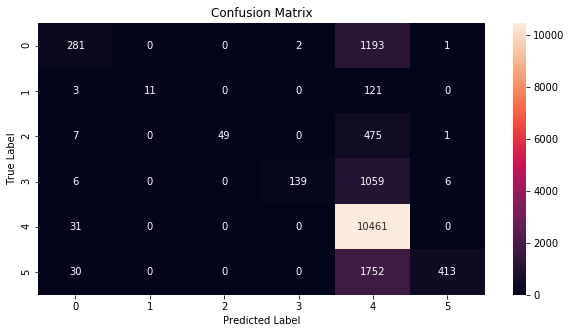

Accuracy Score: 0.7078112337136089


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Predict the review classification based on the training data
y_pred = svc.predict(x_train)

# create heatmap of confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='g')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()

# Print Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_train, y_pred)))

## Improving the Model
There are several key areas that the model can be improved upon. First, There are a lot of features, over 600, these will be reduced by either PCA or by selecting the best 30 features. This will greatly reduce the noise of the data as well as the run time of the model. Both of these models will be compared for accuracy. The next issue is the data of the target variable, 'Y'. The model is biased by the majority outcome which is a rating of 4, as seen in the confusion matrix above. The majority of the errors were in relation to false positives in rating 4. The population will be adjusted so that there will be an equal sample within all populations. The goal of this is to increase the minority outcomes in order to boost the overall accuracy of the model. 

In [12]:
# Assign correlation of 'rating' to variable
df_corr = df.corr()
ser = df_corr['rating'].sort_values()

In [13]:
# Remove correlation of rating with itself
# Print results
ser = ser[:-1]
ser.head()

drink            -0.235009
alcoholic        -0.218739
house & garden   -0.215084
gin              -0.189201
spirit           -0.143103
Name: rating, dtype: float64

In [14]:
# Create a dataframe of top 30 highest correlated variables
large = ser.nlargest(15)
small = ser.nsmallest(15)

variables_list = pd.concat([large,small], axis=0).reset_index()
variables_list.head()

,index,rating
0,bon appétit,0.117422
1,peanut free,0.090484
2,soy free,0.087096
3,tree nut free,0.078344
4,bake,0.070381


In [15]:
# Create variable of the variables from the list
variables = variables_list['index']

## Model 2: Top 30 Features
There was no difference in the top 30 feaatures model from the original model. The cross validation score was slightly higher at .67, but it still suffers from false positives. The test data will not be modeled due to these poor results.

In [16]:
svc = SVC()
# X is the features
X = df[variables]

# Y is the target variable
Y = df['rating']

# Split the data between test and train sets
x_train, x_test, y_train, y_test = train_test_split(X, Y,
        test_size=.2, random_state=1)

# Fit training data
svc.fit(x_train, y_train)

# Cross validation with 5 folds
cross_val_score(svc, x_train, y_train, cv=5)

array([0.66697819, 0.66978193, 0.67196757, 0.66074213, 0.66697848])

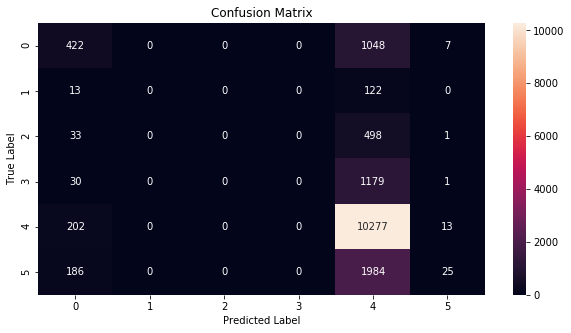

Accuracy Score: 0.6685368742597095


In [17]:
# Predict the review classification based on the training data
y_pred = svc.predict(x_train)

# create heatmap of confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='g')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()

# Print Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_train, y_pred)))

## Model 3: PCA
The PCA of all the features will be calculated. 5 components will be selected due to the eigenvalues. Note that because the features are all boolean ie. 0 or 1 there is no need to normalize the data. This model performed better than the previous two models. The cross validation was similar to the previous two models but the accuracy score was much better. Unfortunately, the accuracy dropped drastically with the test data.

In [23]:
X = df.drop(['title', 'rating'], axis=1)
Y = df['rating']

from sklearn.decomposition import PCA

# Transpose X
Xt = X.T
Cx = np.cov(Xt)

# Calculate the eigenvalues and eigenvectors
eig_val, eig_vec = np.linalg.eig(Cx)

components = 0
for x in eig_val:
    if x > 1:
        components += 1

print('Number of Components: {}'.format(components))

Number of Components: 5


In [24]:
# All components above 1 selected for PCA
sklearn_pca = PCA(n_components=5)
X = sklearn_pca.fit_transform(X)

# Print the percentage for each component
print(
    'The percentage of total variance in the dataset explained by the total',
    'components from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_.sum())

The percentage of total variance in the dataset explained by the total components from Sklearn PCA.
 0.9999999999535611


In [25]:
# Split the data between test and train sets
x_train, x_test, y_train, y_test = train_test_split(X, Y,
        test_size=.2, random_state=1)

svc.fit(x_train, y_train)

cross_val_score(svc, x_train, y_train, cv=5)

array([0.68785047, 0.69127726, 0.68662301, 0.69130028, 0.68880574])

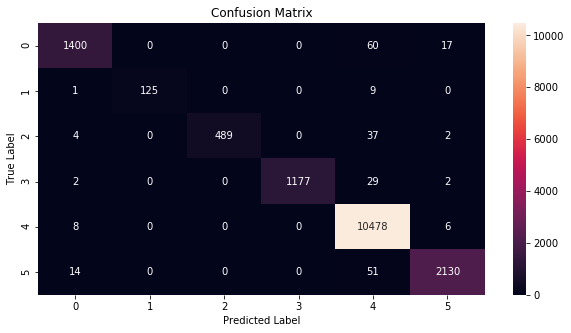

Accuracy Score: 0.9849136587494545


In [26]:
# Predict the review classification based on the training data
y_pred = svc.predict(x_train)

# create heatmap of confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='g')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()

# Print Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_train, y_pred)))

#### Test Data Results

In [27]:
cross_val_score(svc, x_test, y_test, cv=5)

array([0.6778607 , 0.67372354, 0.67372354, 0.6762142 , 0.67919799])

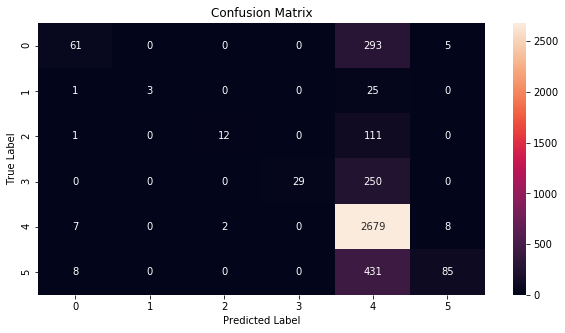

Accuracy Score: 0.7152829718274745


In [28]:
y_pred = svc.predict(x_test)

# create heatmap of confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()

# Print Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))

## Oversampling to 4 Star Rating Population Count
The samples of each rating will be oversampled to match the count of 4 star reviews. 

In [29]:
# Class count
four, five, zero, three, two, one = df['rating'].value_counts()

# Divide by class
df_zero = df[df['rating']==0]
df_one = df[df['rating']==1]
df_two = df[df['rating']==2]
df_three = df[df['rating']==3]
df_four = df[df['rating']==4]
df_five = df[df['rating']==5]

In [30]:
# Count of each review
df['rating'].value_counts()

4    13188
5     2719
0     1836
3     1489
2      656
1      164
Name: rating, dtype: int64

In [31]:
# Increase sample of each review
df_zero_over = df_zero.sample(four, replace=True)
df_one_over = df_one.sample(four, replace=True)
df_two_over = df_two.sample(four, replace=True)
df_three_over = df_three.sample(four, replace=True)
df_five_over = df_five.sample(four, replace=True)

# Append to dataframe
df_over = pd.concat([df_four, df_zero_over, df_one_over, df_two_over, df_three_over, df_five_over], axis=0)

# New count of each values
df_over['rating'].value_counts()

5    13188
4    13188
3    13188
2    13188
1    13188
0    13188
Name: rating, dtype: int64

## Model 4: PCA with Over Sampled Data
This model performed the best. The accuracy score of both the test and train data was over .99. The cross validation score was also excellent. In the training data, the cross validation score was .98, while in the testing data it was .83. The drop in the cross validation score between the train and test data could indicate that this model is overfitted, but it did remove the issue with the type 1 errors. 

In [32]:
X = df_over.drop(['title', 'rating'], axis=1)
Y = df_over['rating']

# Transpose X
Xt = X.T
Cx = np.cov(Xt)

# Calculate the eigenvalues and eigenvectors
eig_val, eig_vec = np.linalg.eig(Cx)

components = 0
for x in eig_val:
    if x > 1:
        components += 1

print('Number of Components: {}'.format(components))

Number of Components: 5


In [33]:
# All components above 1 selected for PCA
sklearn_pca = PCA(n_components=5)
X = sklearn_pca.fit_transform(X)

# Print the percentage for each component
print(
    'The percentage of total variance in the dataset explained by the total',
    'components from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_.sum())

The percentage of total variance in the dataset explained by the total components from Sklearn PCA.
 0.9999999998519045


In [34]:
# Split the data between test and train sets
x_train, x_test, y_train, y_test = train_test_split(X, Y,
        test_size=.2, random_state=1)

# Fit the training data
svc.fit(x_train, y_train)

# Print cross validation score of 5 folds
cross_val_score(svc, x_train, y_train, cv=5)

array([0.98562628, 0.9849155 , 0.9862581 , 0.98625484, 0.98317137])

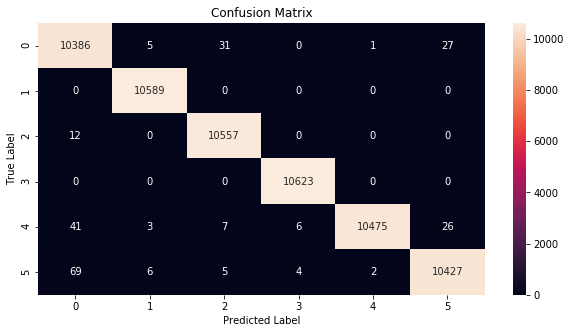

Accuracy Score: 0.9961296641496319


In [35]:
# Predict the review classification based on the training data
y_pred = svc.predict(x_train)

# create heatmap of confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='g')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()

# Print Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_train, y_pred)))

#### Test Data

In [36]:
# Print cross validation score of test data
cross_val_score(svc, x_test, y_test, cv=5)

array([0.84175616, 0.8357549 , 0.8436513 , 0.83033175, 0.83022447])

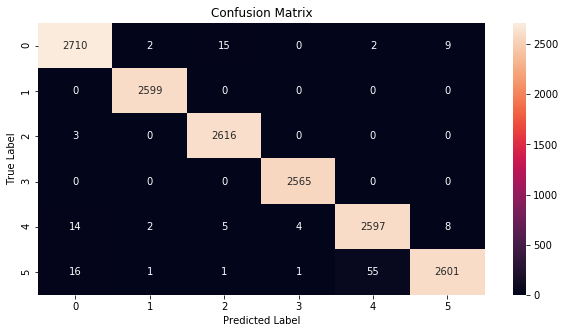

Accuracy Score: 0.9912801718690762


In [37]:
y_pred = svc.predict(x_test)

# create heatmap of confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()

# Print Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))

## Over and Under Sampled Data
The results of the oversampled data were excellent. There was an increase in accuracy for both the train and test group. The amount of Type 1 errors for 4 star reviews decreased drastically between both groups. The only issue is that the model is slightly overfitted as cross validation of the model dropped from .98 to .83. This overfitment could be due to the large increase in the minority classes. Undersampling would not work in this case due to the lack of samples in the minority groups. Lets see what happens to the model when the data is both over and under sampled to say 2000 reviews each. 

In [38]:
# Increase and decrease samples
df_zero_over = df_zero.sample(five, replace=True)
df_one_over = df_one.sample(five, replace=True)
df_two_over = df_two.sample(five, replace=True)
df_three_over = df_three.sample(five, replace=True)
df_four_under = df_four.sample(five, replace=True)

# Concat to dataframe
df_both = pd.concat([df_five, df_zero_over, df_one_over, df_two_over, df_three_over, df_four_under], axis=0)

# Print Count of each review rating
df_both['rating'].value_counts()

5    2719
4    2719
3    2719
2    2719
1    2719
0    2719
Name: rating, dtype: int64

## Model 5: PCA with Over and Under Sampled Data
The data in this model is overfitted. The cross validation score dropped drastically from .74 down to .47. Furthermore, the accuracy of the train and test data also dropped. The training data performed well will 99% accuracy but the test data only had a 76% accuracy score with the majority of the errors being a Type 1 error for review rating 4.  

In [39]:
X = df_both.drop(['title', 'rating'], axis=1)
Y = df_both['rating']

# Transpose X
Xt = X.T
Cx = np.cov(Xt)

# Calculate the eigenvalues and eigenvectors
eig_val, eig_vec = np.linalg.eig(Cx)

components = 0
for x in eig_val:
    if x > 1:
        components += 1

print('Number of Components: {}'.format(components))

Number of Components: 5


In [40]:
# All components above 1 selected for PCA
sklearn_pca = PCA(n_components=5)
X = sklearn_pca.fit_transform(X)

# Print the percentage for each component
print(
    'The percentage of total variance in the dataset explained by the total',
    'components from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_.sum())

The percentage of total variance in the dataset explained by the total components from Sklearn PCA.
 0.9999999994955788


In [41]:
# Split the data between test and train sets
x_train, x_test, y_train, y_test = train_test_split(X, Y,
        test_size=.2, random_state=1)

# Fit the training data
svc.fit(x_train, y_train)

# Cross validation with 5 folds
cross_val_score(svc, x_train, y_train, cv=5)

array([0.73861462, 0.73343547, 0.72988506, 0.75239555, 0.74731595])

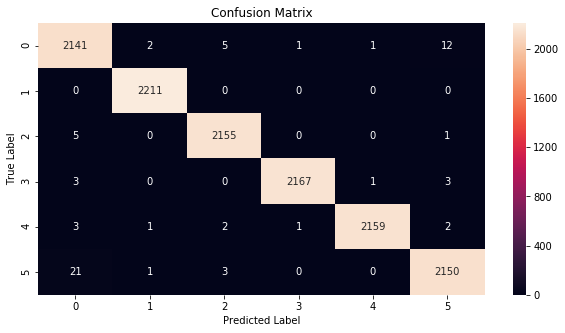

Accuracy Score: 0.9947896712895563


In [42]:
# Predict the review classification based on the training data
y_pred = svc.predict(x_train)

# create heatmap of confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='g')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()

# Print Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_train, y_pred)))

#### Test Data

In [43]:
# Cross validation with test data
cross_val_score(svc, x_test, y_test, cv=5)

array([0.46870229, 0.51376147, 0.50842266, 0.49769585, 0.51692308])

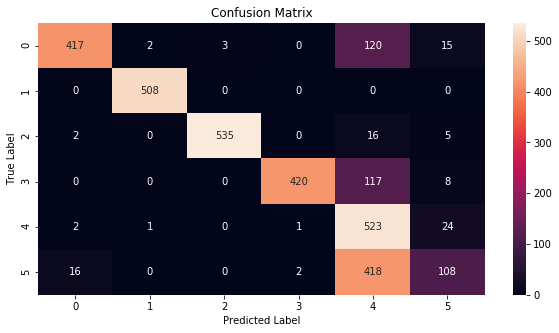

Accuracy Score: 0.7695372356726938


In [44]:
y_pred = svc.predict(x_test)

# create heatmap of confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()

# Print Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))

## Summary and Conclusion
The models were drastically improved from the original model. The top 30 features model performed the same as the original model but the PCA model improved the accuracy of the training data. Unfortunately, it did not perform well with the test data and was overfitted. Out of all the models the best model was model 4, the oversampled PCA, this model correctly predicted the ratings of the data within a 99% accuracy. This model should be used for predicting the reviews of new reciepes added to the epirecipes website. 

## References
Data - https://kaggle.com/hugodarwood/epirecipes